In [9]:
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

In [3]:
with open('yolo-coco-data\\coco.names') as f:
    labels = [line.strip() for line in f]

In [5]:
network = cv2.dnn.readNetFromDarknet('yolo-coco-data\\yolov3.cfg','yolo-coco-data\\yolov3.weights')

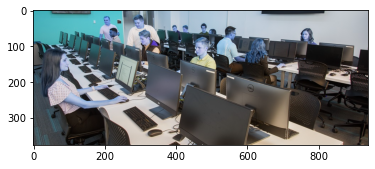

In [10]:
image_BGR = cv2.imread("images/test.jpg")
plt.imshow(image_BGR)

In [14]:
h, w = image_BGR.shape[:2]
print('Image height={0} and width={1}'.format(h, w))

Image height=377 and width=939


In [15]:
blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416),swapRB=True, crop=False)

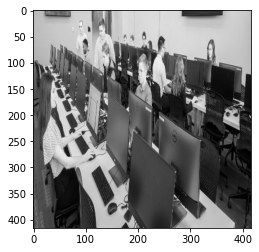

In [21]:
plt.imshow(blob[0][0],cmap = 'gray')

In [23]:
layers_names_all = network.getLayerNames()
layers_names_all

['conv_0',
 'bn_0',
 'relu_1',
 'conv_1',
 'bn_1',
 'relu_2',
 'conv_2',
 'bn_2',
 'relu_3',
 'conv_3',
 'bn_3',
 'relu_4',
 'shortcut_4',
 'conv_5',
 'bn_5',
 'relu_6',
 'conv_6',
 'bn_6',
 'relu_7',
 'conv_7',
 'bn_7',
 'relu_8',
 'shortcut_8',
 'conv_9',
 'bn_9',
 'relu_10',
 'conv_10',
 'bn_10',
 'relu_11',
 'shortcut_11',
 'conv_12',
 'bn_12',
 'relu_13',
 'conv_13',
 'bn_13',
 'relu_14',
 'conv_14',
 'bn_14',
 'relu_15',
 'shortcut_15',
 'conv_16',
 'bn_16',
 'relu_17',
 'conv_17',
 'bn_17',
 'relu_18',
 'shortcut_18',
 'conv_19',
 'bn_19',
 'relu_20',
 'conv_20',
 'bn_20',
 'relu_21',
 'shortcut_21',
 'conv_22',
 'bn_22',
 'relu_23',
 'conv_23',
 'bn_23',
 'relu_24',
 'shortcut_24',
 'conv_25',
 'bn_25',
 'relu_26',
 'conv_26',
 'bn_26',
 'relu_27',
 'shortcut_27',
 'conv_28',
 'bn_28',
 'relu_29',
 'conv_29',
 'bn_29',
 'relu_30',
 'shortcut_30',
 'conv_31',
 'bn_31',
 'relu_32',
 'conv_32',
 'bn_32',
 'relu_33',
 'shortcut_33',
 'conv_34',
 'bn_34',
 'relu_35',
 'conv_35',
 'b

In [25]:
layers_names_output = [layers_names_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]
layers_names_output

['yolo_82', 'yolo_94', 'yolo_106']

In [26]:
probability_minimum = 0.5
threshold = 0.3
colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

In [27]:
network.setInput(blob)  # setting blob as input to the network
output_from_network = network.forward(layers_names_output)

In [28]:
bounding_boxes = []
confidences = []
class_numbers = []

# Going through all output layers after feed forward pass
for result in output_from_network:
    
    # Going through all detections from current output layer
    for detected_objects in result:
        
        # Getting 80 classes' probabilities for current detected object
        scores = detected_objects[5:]
        
        # Getting index of the class with the maximum value of probability
        class_current = np.argmax(scores)
        
        # Getting value of probability for defined class
        confidence_current = scores[class_current]

        # Eliminating weak predictions with minimum probability
        if confidence_current > probability_minimum:
            
            # Scaling bounding box coordinates to the initial image size
            # YOLO data format keeps coordinates for center of bounding box
            # and its current width and height
            # That is why we can just multiply them elementwise
            # to the width and height
            # of the original image and in this way get coordinates for center
            # of bounding box, its width and height for original image
            box_current = detected_objects[0:4] * np.array([w, h, w, h])

            # Now, from YOLO data format, we can get top left corner coordinates
            # that are x_min and y_min
            x_center, y_center, box_width, box_height = box_current
            x_min = int(x_center - (box_width / 2))
            y_min = int(y_center - (box_height / 2))

            # Adding results into prepared lists
            bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
            confidences.append(float(confidence_current))
            class_numbers.append(class_current)

In [29]:
results = cv2.dnn.NMSBoxes(bounding_boxes, confidences,probability_minimum, threshold)

In [30]:
results

array([[ 3],
       [21],
       [12],
       [16],
       [ 6],
       [41],
       [10],
       [55],
       [49],
       [32],
       [40],
       [28],
       [14],
       [ 5],
       [23],
       [37],
       [18],
       [33],
       [53],
       [52],
       [25],
       [48],
       [50],
       [46],
       [26],
       [30],
       [36]], dtype=int32)

In [31]:
counter = 1

# Checking if there is at least one detected object after non-maximum suppression
if len(results) > 0:
    # Going through indexes of results
    for i in results.flatten():
        # Showing labels of the detected objects
        print('Object {0}: {1}'.format(counter, labels[int(class_numbers[i])]))

        # Incrementing counter
        counter += 1

        # Getting current bounding box coordinates,
        # its width and height
        x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
        box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]

        # Preparing colour for current bounding box
        # and converting from numpy array to list
        colour_box_current = colours[class_numbers[i]].tolist()

        # # # Check point
        # print(type(colour_box_current))  # <class 'list'>
        # print(colour_box_current)  # [172 , 10, 127]

        # Drawing bounding box on the original image
        cv2.rectangle(image_BGR, (x_min, y_min),
                      (x_min + box_width, y_min + box_height),
                      colour_box_current, 2)

        # Preparing text with label and confidence for current bounding box
        text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])],
                                               confidences[i])

        # Putting text with label and confidence on the original image
        cv2.putText(image_BGR, text_box_current, (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_COMPLEX, 0.7, colour_box_current, 2)

Object 1: person
Object 2: person
Object 3: person
Object 4: person
Object 5: person
Object 6: keyboard
Object 7: person
Object 8: mouse
Object 9: person
Object 10: chair
Object 11: chair
Object 12: person
Object 13: person
Object 14: tvmonitor
Object 15: tvmonitor
Object 16: tvmonitor
Object 17: tvmonitor
Object 18: tvmonitor
Object 19: keyboard
Object 20: keyboard
Object 21: tvmonitor
Object 22: person
Object 23: tvmonitor
Object 24: chair
Object 25: laptop
Object 26: tvmonitor
Object 27: keyboard


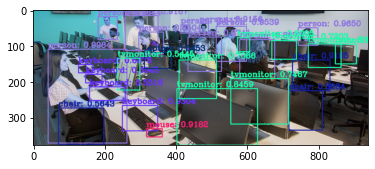

In [32]:
plt.imshow(image_BGR)

In [34]:
def detect_on_image(image_BGR):
    
    h, w = image_BGR.shape[:2]
    blob = cv2.dnn.blobFromImage(image_BGR, 1 / 255.0, (416, 416),swapRB=True, crop=False)
    layers_names_all = network.getLayerNames()
    layers_names_output = [layers_names_all[i[0] - 1] for i in network.getUnconnectedOutLayers()]
    probability_minimum = 0.5
    threshold = 0.3
    colours = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')
    network.setInput(blob)
    output_from_network = network.forward(layers_names_output)
    bounding_boxes = []
    confidences = []
    class_numbers = []
    for result in output_from_network:
        for detected_objects in result:
            scores = detected_objects[5:]
            class_current = np.argmax(scores)
            confidence_current = scores[class_current]

            if confidence_current > probability_minimum:
                box_current = detected_objects[0:4] * np.array([w, h, w, h])
                x_center, y_center, box_width, box_height = box_current
                x_min = int(x_center - (box_width / 2))
                y_min = int(y_center - (box_height / 2))
                bounding_boxes.append([x_min, y_min, int(box_width), int(box_height)])
                confidences.append(float(confidence_current))
                class_numbers.append(class_current)
    
    results = cv2.dnn.NMSBoxes(bounding_boxes, confidences,probability_minimum, threshold)
    counter = 1
    if len(results) > 0:
        for i in results.flatten():
            counter += 1
            x_min, y_min = bounding_boxes[i][0], bounding_boxes[i][1]
            box_width, box_height = bounding_boxes[i][2], bounding_boxes[i][3]
            colour_box_current = colours[class_numbers[i]].tolist()
            cv2.rectangle(image_BGR, (x_min, y_min),(x_min + box_width, y_min + box_height),colour_box_current, 2)
            text_box_current = '{}: {:.4f}'.format(labels[int(class_numbers[i])],confidences[i])
            cv2.putText(image_BGR, text_box_current, (x_min, y_min - 5),cv2.FONT_HERSHEY_COMPLEX, 0.7, colour_box_current, 2)

    return image_BGR

In [35]:
cap = cv2.VideoCapture(0)

while True:
    ret,frame = cap.read()
    
    new = detect_on_image(frame)
    cv2.imshow("frame",new)
    
    key = cv2.waitKey(1)
    if key == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


Image shape: (480, 640, 3)
Image height=480 and width=640
Blob shape: (1, 3, 416, 416)

Objects Detection took 1.29914 seconds
Object 1: person
Object 2: person

Total objects been detected: 8
Number of objects left after non-maximum suppression: 2

Image shape: (480, 640, 3)
Image height=480 and width=640
Blob shape: (1, 3, 416, 416)

Objects Detection took 0.78871 seconds
Object 1: person
Object 2: person
Object 3: person

Total objects been detected: 15
Number of objects left after non-maximum suppression: 3

Image shape: (480, 640, 3)
Image height=480 and width=640
Blob shape: (1, 3, 416, 416)

Objects Detection took 0.71001 seconds
Object 1: person
Object 2: person
Object 3: person

Total objects been detected: 13
Number of objects left after non-maximum suppression: 3

Image shape: (480, 640, 3)
Image height=480 and width=640
Blob shape: (1, 3, 416, 416)

Objects Detection took 0.71561 seconds
Object 1: person
Object 2: person
Object 3: person

Total objects been detected: 12
Nu


Image shape: (645, 400, 3)
Image height=645 and width=400
Blob shape: (1, 3, 416, 416)

Objects Detection took 0.88264 seconds
Object 1: person

Total objects been detected: 4
Number of objects left after non-maximum suppression: 1


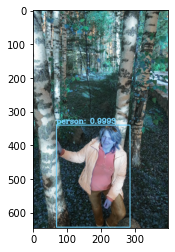

In [44]:
img = cv2.imread("images/0007.jpg")
plt.imshow(detect_on_image(img))